<a href="https://colab.research.google.com/github/geez5/sentimentanalysisTRANSFORMER/blob/main/sentiment_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install dependencies**

In [1]:
!pip install sentence_transformers pinecone-client==3.1.0 datasets seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# **Load and Prepare Dataset**


We use a dataset containing ~90k hotel reviews provided by customers. This dataset can be loaded from the HuggingFace dataset hub as follows:

In [8]:
!git clone https://huggingface.co/datasets/ashraq/hotel-reviews

Cloning into 'hotel-reviews'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13 (from 1)
Unpacking objects: 100% (13/13), 1.95 KiB | 498.00 KiB/s, done.


In [9]:
import pandas as pd

df = pd.read_parquet("hotel-reviews/data/train-00000-of-00001-d30d4a38ef4cc157.parquet")
df.head()


,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


In [17]:
# keep only the first 800 characters from the reviews
df["review"] = df["review"].str[:800]
# glimpse the dataset
df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


# **Initialize Sentiment Analysis Model**



We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [25]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
from transformers import (pipeline, AutoTokenizer,AutoModelForSequenceClassification)

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=3)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer,device=device)

Device set to use cpu


In [27]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [28]:
# view review number 241
test_review = df["review"][241]
test_review

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [29]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.7736573219299316}]

Our pipeline is working as expected and accurately predicts the correct label for the review.

# **Initialize Retriever**

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [30]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Initialize Pinecone Index

Now we need to initialize our Pinecone index. The Pinecone index stores vector representations of our passages which we can retrieve using another vector (the query vector). We first need to initialize our connection to Pinecone. For this, we need a free API key, we initialize the connection:

In [52]:
import os
from pinecone import Pinecone, ServerlessSpec

os.environ["PINECONE_API_KEY"] = "pcsk_551MNB_CovTi4PXcFhtGTc4ukgKUzYSEQXCJsHx99MEB4vPoNgkbxa6UoDq1vqXD53Xj1Z"

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])


Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index.

In [55]:
from pinecone import Pinecone, ServerlessSpec
import time
pc = Pinecone(api_key="pcsk_551MNB_CovTi4PXcFhtGTc4ukgKUzYSEQXCJsHx99MEB4vPoNgkbxa6UoDq1vqXD53Xj1Z")

index_name = "sentiment-mining"
spec = ServerlessSpec(cloud="aws", region="us-east-1")

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,
        metric='cosine',
        spec=spec)
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

index = pc.Index(index_name)
print(index.describe_index_stats())


{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}


Now we can create our vector index. We will name it sentiment-mining. We specify the metric type as cosine and dimension as 384 as these are the vector space and dimensionality of the vectors generated by the retriever model.

In [57]:
index_name = "sentiment-mining"

# Generate Embeddings and Upsert

We generate embeddings for reviews and store them in Pinecone with sentiment labels and scores as metadata to analyze customer opinions.
Now, let’s write a helper function to generate sentiment labels and scores in batches.


In [58]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [59]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['negative', 'neutral', 'positive'],
 [0.9065253138542175, 0.7716172933578491, 0.8975034952163696])

In [63]:
df['review'][0]

' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a specific time though you have to arrange it somehow Parking is far away and hard to come back because of road diversions '

In [64]:
df['review'][1]


' Just the location and view'

In [65]:
df['review'][2]

' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was around the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots close by as well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square as well also a laundry available which is very helpful '

We convert review dates to timestamps to filter results by time, enabling sentiment analysis over specific periods.

In [66]:
import dateutil.parser

# convert date to timestamp
def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [68]:
df['review_date'][0]

'8/3/2017'

In [69]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

Now we create the embeddings. We do this in batches of 64 to avoid overwhelming machine resources or API request limits.

In [71]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["review"].tolist()).tolist()
    # convert review_date to timestamp to enable period filters
    timestamp = get_timestamp(batch["review_date"].tolist())
    batch["timestamp"] = timestamp
    # get sentiment label and score for reviews in the batch
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    { 'label' : 'positive', 'timestamp': 1212121, 'score' : 0.96, 'review' : 'great'}
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()


  0%|          | 0/1465 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
<ipython-input-71-505a0d94bfc6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-input-71-505a0d94bfc6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["score"] = score
<ipython-input-71-505a0d94bfc6>:15: SettingWithCopyWarning: 
A value is trying 

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 93757}},
 'total_vector_count': 93757}

We have successfully indexed all customer reviews and relevant metadata. We can move on to opinion mining.

# Opinion Mining

With reviews indexed, we’ll query room sizes in London and fetch the top 500 results to analyze sentiment using Pinecone.

In [72]:
query = "are the customers satisfied with the room sizes in London hotels?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

In [73]:
result["matches"][:2]

[{'id': '57268',
  'metadata': {'hotel_name': 'Millennium Gloucester Hotel London',
               'label': 'neutral',
               'review': ' The size of the room compared to other london hotels '
                         'And the location and friednly staff ',
               'review_date': '10/9/2015',
               'score': 0.7984866499900818,
               'timestamp': 1444348800.0},
  'score': 0.819348514,
  'values': []},
 {'id': '36931',
  'metadata': {'hotel_name': 'DoubleTree by Hilton London Docklands Riverside',
               'label': 'positive',
               'review': ' Rooms great but on the small size but typical for a '
                         'London hotel',
               'review_date': '11/8/2015',
               'score': 0.8672300577163696,
               'timestamp': 1446940800.0},
  'score': 0.81658715,
  'values': []}]

In [74]:
result["matches"][-2:]

[{'id': '6652',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'neutral',
               'review': ' The rooms are very small',
               'review_date': '4/15/2017',
               'score': 0.5742069482803345,
               'timestamp': 1492214400.0},
  'score': 0.644486547,
  'values': []},
 {'id': '7939',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'neutral',
               'review': ' The rooms are very small ',
               'review_date': '4/15/2016',
               'score': 0.5818774104118347,
               'timestamp': 1460678400.0},
  'score': 0.644486547,
  'values': []}]

We’ll now analyze sentiment on London hotel room sizes by extracting and counting sentiment labels from the search results.


In [76]:
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [77]:
sentiment = count_sentiment(result)
sentiment

{'negative': 55, 'neutral': 165, 'positive': 280}

<Axes: >

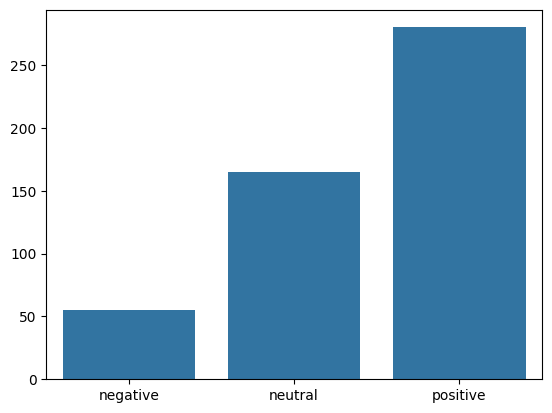

In [78]:
import seaborn as sns

# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

The customers are generally satisfied with the room sizes, although many are still neutral and negative.

We can refine searches using Pinecone’s metadata filters. Let’s filter **room size reviews** from **Dec 25–31, 2015** using timestamp metadata with `$gte` and `$lte`.


In [80]:
# generate timestamps for start and end time of the period
start_time = get_timestamp(["2015-12-25"])[0]
end_time = get_timestamp(["2015-12-31"])[0]


<Axes: >

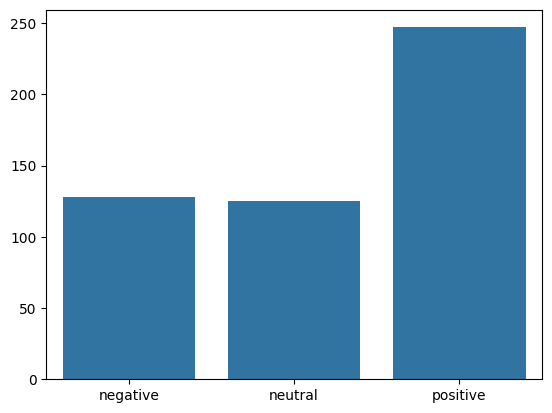

In [81]:
query = "are the customers satisified with the room sizes of hotels in London?"
# generate query embeddings
xq = retriever.encode(query).tolist()
# query pinecone with query embeddings and the period filter
result = index.query(
    vector=xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})
# get an overall count of customer sentiment
sentiment = count_sentiment(result)
# plot a barchart using seaborn
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))

We have a slightly different result now. Almost the same number of customers had either a neutral or negative view of the room size during the selected period.

In [82]:
hotels =[
    "Strand Palace Hotel",
    "Britannia International Hotel Canary Wharf",
    "Grand Royale London Hyde Park",
    "Intercontinental London The O2",
]

In [83]:
queries = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC"
}


We’ll loop through all hotels, run queries for each, count sentiment labels, and plot the results.


In [86]:
import matplotlib.pyplot as plt
import pandas as pd

hotel_sentiments = []
for hotel in hotels: # iterate through the hotels
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(vector=xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {"area": area, "label": k, "value": v}
            # add the data to result list
            result.append(data)
    # convert the
    hotel_sentiments.append({"hotel": hotel, "df": pd.DataFrame(result)})

Let's see what our final data look like.

In [87]:
hotel_sentiments[0]["df"]

,area,label,value
0,Room Size,negative,126
1,Room Size,neutral,188
2,Room Size,positive,186
3,Cleanliness,negative,88
4,Cleanliness,neutral,64
5,Cleanliness,positive,348
6,Staff,negative,69
7,Staff,neutral,35
8,Staff,positive,396
9,Food,negative,96


We may now plot the final data to make inference.

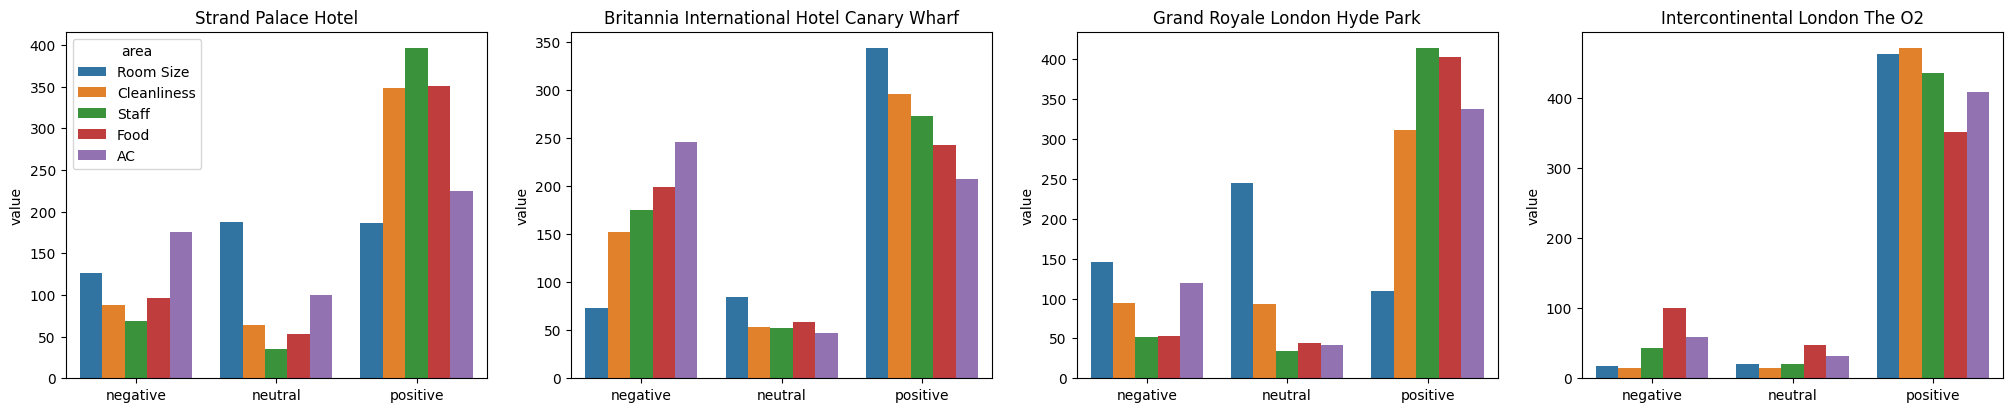

In [88]:
# create the figure and axes to plot barchart for all hotels
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0
# iterate through each hotel in the list and plot a barchart
for d, ax in zip(hotel_sentiments, axs.ravel()):
    # plot barchart for each hotel
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax)
    # display the hotel names
    ax.set_title(d["hotel"])
    # remove x labels
    ax.set_xlabel("")
    # remove legend from all charts except for the first one
    counter += 1
    if counter != 1: ax.get_legend().remove()
# display the full figure
plt.show()

What the sentiment analysis reveals about each hotel:

Strand Palace Hotel: Guests generally had a positive experience with the staff, food, and room cleanliness. However, many were disappointed with the small room sizes and the air conditioning.

Britannia International Hotel Canary Wharf: Room size got good feedback, but the air conditioning was a common complaint.

Grand Royale London Hyde Park: Most guests were unhappy with the room sizes, though many appreciated the food, staff, AC, and cleanliness.

Intercontinental London The O2: This hotel stood out. Guests were overwhelmingly satisfied across all five key areas, making it the top performer in our analysis.



